# Convolutional Neural Networks

## From Fully-Connected Layers to Convolutions for image recognition.

So far: Feedforward Neural Nets

* We did not assume any structure a priori concerning how the features interact.
* We used e.g. Fully-Connected Layers.
* We dived into the inner mechanics of learning through gradient descent.
* PyTorch offers facilities to build models and optimize them.

Now: Imgage Recognition

* Convolutional neural networks (CNNs) are one creative waythat machine learning has embraced for exploiting some of the known structure in natural images.
* Image recognition is arguably the task that made the world realize the potential of deep learning.

### Case Study
In the follwing, we consider the data set CIFAR-10 that consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes: 
* airplane (0), automobile (1), bird (2), cat (3),
deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9).

We aim to build a neural net that classifies the images. 

First, we load the data set and split the data into trainings and validation set.

In [1]:
import PIL
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


To speed up calculations, we are running the calculation on GPUs.
Let us check the number of available GPUs.

Then, we set the class names and have a look at the first twenty images in the data set.

D:\Uni\Anaconda\envs\deeplearn-env2\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


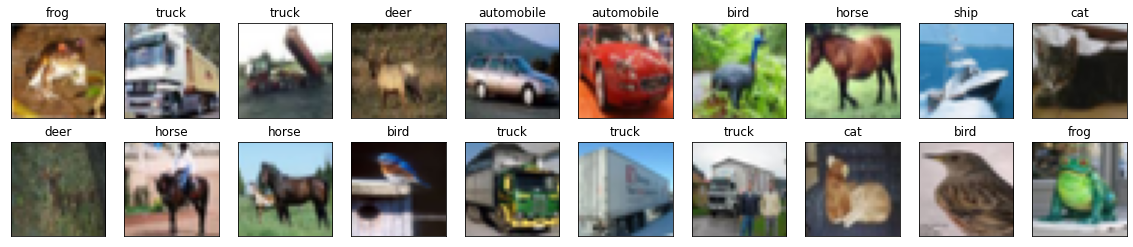

In [3]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img, label = cifar10[idx]
    plt.imshow(img)
    ax.set_title(class_names[label])

Remark that images consist of 3 channels: red, green, and blue. In reality, images are not two-dimensional objects but rather third-order tensors, characterized by a height, width, and channel, e.g., with shape 1024×1024×3 pixels.

In our analysis, we only focus on images of cats and dogs. Let us have a look at these images:

D:\Uni\Anaconda\envs\deeplearn-env2\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


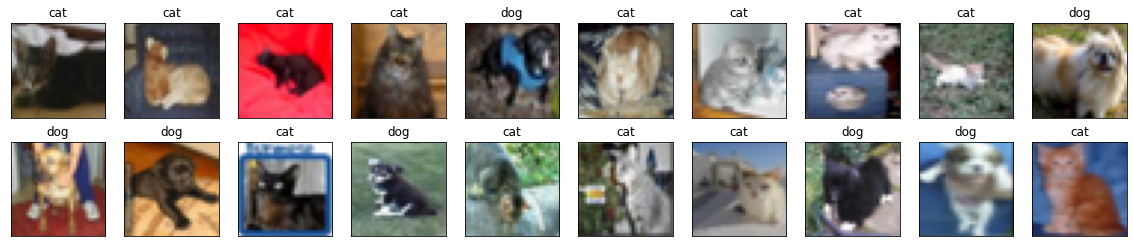

In [4]:
label_map = {3: 0, 5: 1}
class_names = ['cat', 'dog']
cifar_dogcat = [(img, label_map[label]) 
         for img, label in cifar10
         if label in [3, 5]]
fig = plt.figure(figsize=(20, 4)) # display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img, label = cifar_dogcat[idx]
    plt.imshow(img)
    ax.set_title(class_names[label])

#### Spatial Configuration of Images

* We aim to build a neural network that helps to classfy cats and dogs. 

* We have already learned how to build a (fully-connected) feed forward neural network. 

* However, how to handle the spatial configuration of an image? 

* In theory, we could just take the image pixels and straighten them into a long 1D vector and consider those numbers as input features. This is what the next figure illustrates:

![fullyconnect.png](figures/Conv/fullyconnect.png)

#### Data preperation

Before we build our network, we need to prepare the data by transforming the data into tensors and normalizing the features.

In [5]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.ToTensor())
img_t, _ = tensor_cifar10[7]
type(img_t)

torch.Tensor

In [6]:
transformed_cifar10 = datasets.CIFAR10(
data_path, train=True, download=False,
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4915, 0.4823, 0.4468),
(0.2470, 0.2435, 0.2616))
]))

transformed_cifar10_val = datasets.CIFAR10(
data_path, train=False, download=False,
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4915, 0.4823, 0.4468),
(0.2470, 0.2435, 0.2616))
]))

label_map = {3: 0, 5: 1}
class_names = ['cat', 'dog']
cifar2 = [(img, label_map[label]) 
         for img, label in transformed_cifar10
         if label in [3, 5]]

cifar2_val = [(img, label_map[label])
             for img, label in transformed_cifar10_val
             if label in [3, 5]]

The image has been turned into a 3 × 32 × 32 tensor and therefore a 3-channel (RGB) 32 × 32 image. We also created a Dataset subclass that only includes cats and dogs. But, how many features per sample do we have? Well, 32 × 32 × 3: that is, 3,072 input features!

#### Categorical Outputs

* We need to recognize that the output is categorical, such as [1, 0] for cat or [0, 1] for dog. 
* In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an cat
and torch.tensor([0.0, 1.0]) for a dog. 
* We can expect the network to output something in between. The key realization in this case is that we can interpret our output as probabilities: the first entry is the probability of “car,” and the second is the probability of “bird.”

Casting the problem in terms of probabilities imposes a few extra constraints on
the outputs of our network:

* Each element of the output must be in the [0.0, 1.0] range (a probability ofan outcome cannot be less than 0 or greater than 1).
* The elements of the output must add up to 1.0 (we’re certain that one of the two outcomes will occur).

There’s a very smart trick that does exactly that, and it’s differentiable: it’s called **softmax**.

#### Softmax: Representing the output as probabilies

* Softmax is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints we just listed to represent probabilities.  

* It takes the elements of the vector, compute the elementwise exponential, and divide each element by the sum of exponentials:

$$softmax(x_1,\dots,x_J)=\left(\frac{\exp(x_1)}{\exp(x_1)+\dots+\exp(x_J)},\dots,\frac{\exp(x_J)}{\exp(x_1)+\dots+\exp(x_J)}\right).$$


* In our case, we have $J=2$. Thus the function above simplifies to 

$$softmax(x_1,x_2)=\left(\frac{\exp(x_1)}{\exp(x_1)+\exp(x_2)},\frac{\exp(x_2)}{\exp(x_1)+\exp(x_2)}\right).$$

In Python:

In [7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()


Let’s test it on an arbitrary input vector:

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

As expected, it satisfies the constraints on probability. 

Now, let us build the model. We have added a softmax at the end of our model that produces probabilities.

In [9]:
model = nn.Sequential(
nn.Linear(3072, 512),
nn.Tanh(),
nn.Linear(512, 2),
nn.LogSoftmax(dim=1))

* We somewhat arbitrarily pick 512 hidden features. 
* A neural network needs at least one hidden layer (of activations, so two modules) with a nonlinearity in between in order to be able to learn arbitrary functions. 
* The hidden features represent (learned) relations between the inputs encoded through the weight matrix. 
* Let us try our model with the first image in our data set. Remark that we need to flatten the input first in order to make it have the right dimensions. 



In [10]:
img, _ = cifar2[1]
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out

tensor([[-0.9174, -0.5101]], grad_fn=<LogSoftmaxBackward>)

The weights and
biases of our linear layers have not been trained at all. Their elements are initialized
randomly by PyTorch between –1.0 and 1.0

#### Training the classifier

* The torch.utils.data module has a class that helps with shuffling and organizing the data in minibatches: **DataLoader**. 

* The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies.

* A very common strategy is uniform sampling after shuffling the data at each epoch.

* The DataLoader constructor takes a Dataset object as input, along with batch_size and a shuffle Boolean that indicates whether the data needs to be shuffled at the beginning of each epoch:

In [11]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)

![DataLoader.png](figures/Conv/DataLoader.png)

from Stevens, E. and Antiga, L. and Viehmann, T.: Deep Learning with PyTorch (2020).

Let us train the model.

In [12]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 50
for epoch in range(n_epochs):
    for img, label in train_loader:
        batch_size = img.shape[0]
        outputs = model(img.view(batch_size, -1))
        loss = loss_fn(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))  

Epoch: 0, Loss: 0.681694
Epoch: 1, Loss: 0.521168
Epoch: 2, Loss: 0.670650
Epoch: 3, Loss: 0.599375
Epoch: 4, Loss: 0.653458
Epoch: 5, Loss: 0.637871
Epoch: 6, Loss: 0.630998
Epoch: 7, Loss: 0.607943
Epoch: 8, Loss: 0.558896
Epoch: 9, Loss: 0.610029
Epoch: 10, Loss: 0.594848
Epoch: 11, Loss: 0.661597
Epoch: 12, Loss: 0.520240
Epoch: 13, Loss: 0.636401
Epoch: 14, Loss: 0.548240
Epoch: 15, Loss: 0.483564
Epoch: 16, Loss: 0.510832
Epoch: 17, Loss: 0.625786
Epoch: 18, Loss: 0.617438
Epoch: 19, Loss: 0.610310
Epoch: 20, Loss: 0.572571
Epoch: 21, Loss: 0.396773
Epoch: 22, Loss: 0.395230
Epoch: 23, Loss: 0.332968
Epoch: 24, Loss: 0.430567
Epoch: 25, Loss: 0.460557
Epoch: 26, Loss: 0.519198
Epoch: 27, Loss: 0.222548
Epoch: 28, Loss: 0.585951
Epoch: 29, Loss: 0.381460
Epoch: 30, Loss: 0.479133
Epoch: 31, Loss: 0.367894
Epoch: 32, Loss: 0.309790
Epoch: 33, Loss: 0.250094
Epoch: 34, Loss: 0.205856
Epoch: 35, Loss: 0.264657
Epoch: 36, Loss: 0.148504
Epoch: 37, Loss: 0.210580
Epoch: 38, Loss: 0.334

We see that the loss decreases somehow, but we have no idea whether it’s low enough.

Since our goal here is to correctly assign classes to images, and preferably do that on an independent dataset, we can compute the accuracy of our model on the validation set in terms of the number of correct classifications over the total:

In [13]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: {:.4f}" .format(correct / total))

Accuracy: 0.6050


Not a great performance, but better than random. It was quite a shallow classifier; it’s a miracle that it worked at all. It did because our dataset is really simple — a lot of the samples in the two classes likely have systematic differences.

#### The problem of overfitting

* PyTorch offers a quick way to determine how many parameters a model has through the parameters() method of nn.Model (the same method we use to provide the parameters to the optimizer). To find out how many elements are in each tensor instance, we can call the numel method. Summing those gives us our total count.

* Depending on our use case, counting parameters might require us to check whether a parameter has requires_grad set to True, as well. We might want to differentiate the number of trainable parameters from the overall model size. 

Let’s take a look at what we have right now:

In [14]:
numel_list = [p.numel()for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

* We have in total **1574402** trainable parameters even in our shallow network. Not a small number for such a small input image, is it?

* And our neural network won’t scale very well with the number of pixels. What if we had a 1,024 × 1,024 RGB image? That’s 3.1 million input values.

* Even abruptly going to 1,024 hidden features (which is not going to work for our classifier), we would have over 3 billion parameters. 

* Unless we have lots of GPUs, a talent for distributed optimization, and an extraordinary amount of patience, learning the parameters of this network may turn out to be infeasible.

#### The limits of going fully connected

Treating an image as one big vector of numbers has the following shortcomings:

* Aren’t utilizing the relative position of neighboring or faraway
pixels.

* Loosing spatial information

* A fully connected network is not translation invariant.

* Mismatch between the problem and the network
structure

* Overfitting the training data, rather than learning the generalized
features of what we want the model to detect

**Solution:** Convolutional Networks

The ideas and main conceps of Convolutional Networks will be discussed in the next lecture.

## Convolutional Networks

* In the previous chapter, we have built a simple neural network that could fit (or overfit)
the data, thanks to the many parameters available for optimization in the linear layers.

* There is a better way! It consists of replacing the dense, fully connected affine transformation
in our neural network unit with a different linear operation: **convolution**.

* **Convolutional networks** (LeCun, 1989), also known as Convnets, or CNNs, employ convolutions to process data that has a known grid-like topology (e.g., image data).

* We will see how convolutions deliver **locality** and **translation invariance**.

Basic conceps

* **Translation invariance** in images implies that all patches of an image will be treated in the same manner.

* **Locality** means that only a small neighborhood of pixels will be used to compute the corresponding hidden representations.

* In image processing, convolutional layers typically require many fewer parameters than fully-connected layers.

* Channels on input and output allow our model to capture multiple aspects of an image  at each spatial location.

### Convolutions

* If we want to recognize patterns corresponding to objects, like an airplane in the sky, we will likely need to look at how nearby pixels are arranged, and we will be less interested in how pixels that are far from each other appear in combination.

* In order to translate this intuition into mathematical form, we could compute the
weighted sum of a pixel with its immediate neighbors, rather than with all other pixels
in the image.

* Before going further, we should briefly review
why the above operation is called a convolution.
In mathematics, the *convolution* between two functions,
say $f, g: \mathbb{R}^d \to \mathbb{R}$ is defined as
$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$ That is, we measure the overlap between $f$ and $g$
when one function is "flipped" and shifted by $\mathbf{x}$.

* Whenever we have discrete objects, the integral turns into a sum. For instance, for vectors from the set of square summable infinite dimensional vectors with index running over $\mathbb{Z}$ we obtain the following definition:


$$(f * g)(i) = \sum_a f(a) g(i-a).$$

* In convolutional network terminology, the ﬁrst argument (in this example, the function f) to the convolution is often referred to as the **input**, and the second argument (in this example, the function g) as the **kernel**. The output is sometimes referred to as the **feature map**.

#### Convolutions for Images

* Convolution  is defined for a 2D image as the scalar product of a weight matrix, the **kernel**, with every neighborhood in the input. 

* A convolutional layer cross-correlates the input and kernel and adds a scalar **bias** to produce an output.

* Hence, the two parameters of a convolutional layer are the kernel and the scalar bias.

* When training models based on convolutional layers, we typically initialize the kernels randomly, just as we would with a fully-connected layer.

* Let us ignore the (colour) channels for now and see how this works with two-dimensional data and hidden representations.
* In our first example, the input is a two-dimensional tensor with a height of 3 and width of 3. 
* The shape of the *kernel window* (or *convolution window*) is given by the height and width of the kernel
(here it is $2\times 2$).
* The output tensor has a height of 2 and width of 2 and the four elements are derived from the two-dimensional cross-correlation operation:

<center>
<img src="./figures/Conv/correlation.svg" alt="Drawing" style="width: 500px;"/></center>

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$


We can construct the input tensor X and the kernel tensor K in Python to validate the output of the two-dimensional cross-correlation operation.

In [15]:
from d2l import torch as d2l
import torch
from torch import nn

def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = d2l.reduce_sum((X[i: i + h, j: j + w] * K))
    return Y

In [16]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

#### Computational Efficiency

* A key insight with a convolution layer is that the number of parameters depends not on the number of pixels in the image, as was the case in our fully connected model, but rather on the size of the convolution kernel (3 × 3, 5 × 5, and so on) and on how many convolution filters (or output channels) we decide to use in our model.

* Convolutional networks typically have sparse interactions (also referred to as sparse connectivity or sparse weights). This is accomplished by making the kernel smaller than the input.

* For example, when processing an image, the input image might have thousands or millions of pixels, but we can detect small, meaningful features such as edges with kernels that occupy only tens or hundreds of pixels. 

* This means that we need to store fewer parameters, which both reduces the memory requirements of the model and improves its statistical eﬃciency. These improvements in eﬃciency are usually quite large.


#### Summary - Convolutional Layers

* The core computation of a two-dimensional convolutional layer is a two-dimensional cross-correlation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.

* We can design a kernel to detect edges in images.

* We can learn the kernel's parameters from data.

* With kernels learned from data, the outputs of convolutional layers remain unaffected regardless of such layers' performed operations (either strict convolution or cross-correlation).

* When any element in a feature map needs a larger receptive field to detect broader features on the input, a deeper network can be considered.

Let us have a look at another example:

<center>
<img src="./figures/Conv/no_padding_no_strides-001.png" alt="Drawing" style="width: 250px;"/></center>

[1] Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning (BibTeX)
 
The input had both a height and width of 4 and our convolution kernel had both a height and width of 2,
yielding an output representation with dimension $2\times2$. Therefore, the output shape of the convolutional layer
is determined by the shape of the input and the shape of the convolution kernel. We’re missing two pixels in each dimension!


### Padding

* As motivation, note that since kernels generally have width and height greater than $1$, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input.

* If we start with a $240 \times 240$ pixel image, $10$ layers of $5 \times 5$ convolutions reduce the image to $200 \times 200$ pixels, slicing off $30 \%$ of the image and with it obliterating any interesting information on the boundaries of the original image.

* *Padding* is the most popular tool for handling this issue.

* *Padding* adds extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to zero.

* PyTorch gives us the possibility of padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned.

<center>
<img src="./figures/Conv/full_padding_no_strides-001.jpg" alt="Drawing" style="width: 250px;"/></center>

<center>
<img src="./figures/Conv/full_padding_no_strides-002.jpg" alt="Drawing" style="width: 250px;"/></center>

### Stride

* In other cases, we may want to reduce the dimensionality drastically, e.g., if we find the original input resolution to be unwieldy.

* *Strided convolutions* are a popular technique that can help in these instances.

* When computing the cross-correlation, we start with the convolution window at the top-left corner of the input tensor, and then slide it over all locations both down and to the right.

* In previous examples, we default to sliding one element at a time. 

* However, for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations.

* We refer to the number of rows and columns traversed per slide as the **stride**.

So far, we have used strides of 1, both for height and width. Sometimes, we may want to use a larger stride. Let us have a look at another example.


<center>
<img src="./figures/Conv/padding_strides-001.png" alt="Drawing" style="width: 250px;"/></center>

<center>
<img src="./figures/Conv/padding_strides-002.png" alt="Drawing" style="width: 250px;"/></center>

#### Exercise

What stride are we using here? Are we using padding? Describe the effect of downsampling in the example above.

#### Summary

* Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.


* The stride can reduce the resolution of the output by reducing the height and width of the output.


* Padding and stride can be used to adjust the dimensionality of the data effectively.

### What about the big picture?

* We got all excited because by moving from fully connected layers to convolutions, we achieve locality and translation invariance. 

* We recommended the use of small kernels, like 3 × 3, or 5 × 5: that’s peak locality. 

* However, how do we know that all structures in our images are 3 pixels or 5 pixels wide? We don’t, because they aren’t. 

* How are our networks going to be equipped to see those patterns with larger scope?

* One option, which is used in convolutional neural networks, is stacking one convolution after the other and at the same time **downsampling** the image between successive convolutions.

### Downsampling 
Downsampling could in principle occur in different ways. Scaling an image by half is
the equivalent of taking four neighboring pixels as input and producing one pixel as
output. How we compute the value of the output based on the values of the input is
up to us. We could

* Average the four pixels. This average pooling was a common approach early on but has fallen out of favor somewhat.
* Take the maximum of the four pixels. This approach, called max pooling, is currently the most commonly used approach, but it has a downside of discarding the other three-quarters of the data.
* Perform a strided convolution, where only every nth pixel is calculated. For example, a 3 × 4 convolution with stride 2 still incorporates input from all pixels from the previous layer.


Next, we introduce **pooling layers**, which serve the dual purposes of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations.

### Pooling

* As we process images, we want to gradually reduce the spatial resolution of our hidden representations, aggregating information so that the higher up we go in the network, the larger the receptive field (in the input) to which each hidden node is sensitive.

* Often our ultimate task asks some global question about the image, e.g., *does it contain a cat?*

* So typically the units of our final layer should be sensitive to the entire input.

* By gradually aggregating information, yielding coarser and coarser maps, we accomplish this goal of ultimately learning a global representation, while keeping all of the advantages of convolutional layers at the intermediate layers of processing.

* Like convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (the **pooling window**). 

* However, unlike the cross-correlation computation of the inputs and kernels in the convolutional layer, the pooling layer contains **no** parameters (there is no kernel). Instead, pooling operators are deterministic.

#### The max-pooling operation

* Max pooling can be used to aggressively downsample feature maps

* Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. 

* One of the major benefits of a pooling layer is to alleviate the excessive sensitivity of the convolutional layer to location.

* We can specify the padding and stride for the pooling layer.

* Maximum pooling, combined with a stride larger than 1 can be used to reduce the spatial dimensions (e.g., width and height).

* The pooling layer’s number of output channels is the same as the number of input channels

#### Example 
We can think of the pooling window as starting from the top left of the input tensor and sliding across the input tensor from left to right and top to bottom. At each location that the pooling window hits, it computes the maximum of the input subtensor in the window:

<center>
<img src="./figures/Conv/pooling.svg" alt="Drawing" style="width: 400px;"/></center>

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

We can also write a function in Pytorch that applies the max-pooling (or average-pooling) operation:

In [17]:
from d2l import torch as d2l
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [18]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

More generally, max pooling is also provided by the nn.MaxPool2d module in Pytorch (as with convolution, there are
versions for 1D and 3D data):

In [19]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
X = d2l.reshape(torch.arange(9, dtype=torch.float32), (1, 1, 3, 3))
pool = nn.MaxPool2d(2,padding=0,stride=1)
pool(X)

tensor([[[[4., 5.],
          [7., 8.]]]])

### Multiple Input Channels

* Analyzing color data, one is faced with multiple channel data.

* Color images have the standard RGB channels to indicate the amount of red, green and blue.

* We demonstrate an example of a two-dimensional cross-correlation with two input channels.

<center>
<img src="./figures/Conv/conv-multi-in.svg" alt="Drawing" style="width: 600px;"/></center>

from Aston Zhang, Zachary C. Lipton, Mu Li and Alexander J. Smola: "Dive Into Deep Learning" (https://d2l.ai/)

The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: (1×1+2×2+4×3+5×4)+(0×0+1×1+3×2+4×3)=56.

To make sure we really understand what is going on here,
we can implement cross-correlation operations with multiple input channels ourselves.
Notice that all we are doing is performing one cross-correlation operation
per channel and then adding up the results.

In [20]:
from d2l import torch as d2l
import torch

def corr2d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [21]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### Summary 

By switching to convolutions, we get
* Local operations on neighborhoods
* Translation invariance
* Models with a lot fewer parameters

Hence, Convnets are the best tool for attacking visual-classification problems.

### Outlook: CNN Architectures

![convcomplete.png](figures/Conv/convcomplete.png)

The process of learning with convolutions by estimating the gradient at the kernel weights and
updating them individually in order to optimize for the loss (cf. Stevens et al: Deep Learning with PyTorch (2020)).

## Modern Convolutional Neural Networks

* So far, we have understood the basics of CNNs

* Now, we will consider modern CNN architectures. 

* Each of the following networks was briefly a dominant architecture and many were winners or runners-up in the ImageNet competition, which has served as a barometer of progress on supervised learning in computer vision since 2010.

### LeNet

* First, we will introduce LeNet, among the first published CNNs to capture wide attention for its performance on computer vision tasks.

* The model was introduced by (and named for) Yann LeCun (1998), a researcher at AT&T Bell Labs, for the purpose of recognizing handwritten digits in images.

* This work represented the culmination of a decade of research developing the technology. 

* In 1989, LeCun published the first study to successfully train CNNs via backpropagation.

At a high level, LeNet (LeNet-5) consists of two parts: 

(i) a convolutional encoder consisting of two convolutional layers; and 
(ii) a dense block consisting of three fully-connected layers:

![lenet.svg](figures/Conv/lenet.svg)

* The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. 
* Note that while ReLUs and max-pooling work better, these discoveries had not yet been made in the 1990s.
* LeNet was arguably the first successful deployment of such a network.


### AlexNet

* AlexNet, which employed an 8-layer CNN, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a phenomenally large margin. 

* This network showed, for the first time, that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

* First, let us compare the AlexNet (2012) to the LeNet (1998):

<center>
<img src="./figures/Conv/alexnet.svg" alt="Drawing" style="width: 300px;"/></center>

#### The architecture of AlexNet


The design philosophies of AlexNet and LeNet are very similar, but there are also significant differences:
* AlexNet is much deeper than the comparatively small LeNet5.

* AlexNet consists of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer. 

* AlexNet used the ReLU instead of the sigmoid as its activation function. 

* AlexNet used the max-pooling instead of the average-pooling.

#### Summary

* Today AlexNet has been surpassed by much more effective architectures but it is a key step from shallow to deep networks that are used nowadays.

* Although it seems that there are only a few more lines in AlexNet’s implementation than in LeNet, it took the academic community many years to embrace this conceptual change and take advantage of its excellent experimental results. This was also due to the lack of efficient computational tools

* Dropout, ReLU, and preprocessing were the other key steps in achieving excellent performance in computer vision tasks.

### Networks Using Blocks (VGG)

* While AlexNet offered empirical evidence that deep CNNs can achieve good results, it did not provide a general template to guide subsequent researchers in designing new networks.

* Later, the design of neural network architectures had grown progressively more abstract, with researchers moving from thinking in terms of individual neurons to whole layers, and then to blocks, repeating patterns of layers.

* The idea of using blocks first emerged from the Visual Geometry Group (VGG) at Oxford University, in their eponymously-named VGG network. 

* It is easy to implement these repeated structures in code with any modern deep learning framework by using loops and subroutines.

<center>
<img src="./figures/Conv/vgg.svg" alt="Drawing" style="width: 400px;"/></center>

#### Summary 

* Like AlexNet and LeNet, the VGG Network can be partitioned into two parts: the first consisting mostly of convolutional and pooling layers and the second consisting of fully-connected layers.

* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.

* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.

### Network in Network (NiN)

* LeNet, AlexNet, and VGG all share a common design pattern: extract features exploiting spatial structure via a sequence of convolution and pooling layers and then post-process the representations via fully-connected layers.

* The use of dense layers might give up the spatial structure of the representation entirely, network in network (NiN) blocks offer an alternative (2013).

* They are based on a very simple insight: to use an MLP on the channels for each pixel separately.

* NiN uses blocks consisting of a convolutional layer and multiple 1×1 convolutional layers. This can be used within the convolutional stack to allow for more per-pixel nonlinearity.

* NiN removes the fully-connected layers and replaces them with global average pooling (i.e., summing over all locations) after reducing the number of channels to the desired number of outputs (e.g., 10 for Fashion-MNIST).

* Removing the fully-connected layers reduces overfitting. NiN has dramatically fewer parameters.

* The NiN design influenced many subsequent CNN designs.

<center>
<img src="./figures/Conv/NiN.png" alt="Drawing" style="width: 600px;"/></center>

### Networks with Parallel Concatenations (GoogLeNet)

* In 2014, GoogLeNet won the ImageNet Challenge, proposing a structure that combined the strengths of NiN and paradigms of repeated blocks (Szegedy et al., 2015).

* The idea was to address the question of which sized convolution kernels are best. After all, previous popular networks employed choices as small as 1×1 and as large as 11×11. 

* One insight in this paper was that sometimes it can be advantageous to employ a combination of variously-sized kernels.

* In the following, we will introduce a slightly simplified version of the original GoogLeNet.

#### Inception blocks

The basic convolutional block in GoogLeNet is called an *Inception block*, likely named due to a quote from the movie Inception (“We need to go deeper”), which launched a viral meme.

<center>
<img src="./figures/Conv/inception.svg" alt="Drawing" style="width: 600px;"/></center>

* The inception block consists of four parallel paths. 

* The first three paths use convolutional layers with window sizes of 1×1, 3×3, and 5×5 to extract information from different spatial sizes. 

* The middle two paths perform a 1×1 convolution on the input to reduce the number of channels, reducing the model’s complexity. 

* The fourth path uses a 3×3 maximum pooling layer, followed by a 1×1 convolutional layer to change the number of channels. The four paths all use appropriate padding to give the input and output the same height and width. 

* Finally, the outputs along each path are concatenated along the channel dimension and comprise the block’s output. The commonly-tuned hyperparameters of the Inception block are the number of output channels per layer.

To gain some intuition for why this network works so well, consider the combination of the filters. They explore the image in a variety of filter sizes. This means that details at different extents can be recognized efficiently by filters of different sizes. At the same time, we can allocate different amounts of parameters for different filters.

 #### GoogLeNet Model
 
* GoogLeNet uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. 

* Maximum pooling between inception blocks reduces the dimensionality. 

* The first module is similar to AlexNet and LeNet. The stack of blocks is inherited from VGG and the global average pooling avoids a stack of fully-connected layers at the end.

<center>
<img src="./figures/Conv/inception-full.svg" alt="Drawing" style="width:200px;"/></center>

#### Summary

* The Inception block is equivalent to a subnetwork with four paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers.

* 1x1 convolutions reduce channel dimensionality on a per-pixel level. Maximum pooling reduces the resolution.

* GoogLeNet connects multiple well-designed Inception blocks with other layers in series. The ratio of the number of channels assigned in the Inception block is obtained through a large number of experiments on the ImageNet dataset.

* GoogLeNet, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.

### Residual Networks (ResNet)

* As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network. 

* Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different. 

* At the heart of their proposed residual network (ResNet) is the idea that every additional layer should more easily contain the identity function as one of its elements.

* These considerations are rather profound but they led to a surprisingly simple solution, a residual block. 

* ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015 and the design had a profound influence on how to build deep neural networks.

#### Residual Blocks

Denote the input by x. We assume that the desired underlying mapping we want to obtain by learning is f(x).

<center>
<img src="./figures/Conv/residual-block.svg" alt="Drawing" style="width:400px;"/></center>



* On the left figure, the portion within the dotted-line box must directly learn the mapping f(x).
* On the right, the portion within the dotted-line box needs to learn the residual mapping f(x)−x, which is how the residual block derives its name.
* The residual block of ResNet, where the solid line carrying the layer input x to the addition operator is called a residual connection (or shortcut connection). 
* With residual blocks, inputs can forward propagate faster through the residual connections across layers.

#### ResNet Model

* The first two layers of ResNet are the same as those of the GoogLeNet we described before: the 7×7 convolutional layer with 64 output channels and a stride of 2 is followed by the 3×3 maximum pooling layer with a stride of 2. 

* The difference is the batch normalization layer added after each convolutional layer in ResNet.

* GoogLeNet uses four modules made up of Inception blocks. However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels.


<center>
<img src="./figures/Conv/resmodel.png" alt="Drawing" style="width:800px;"/></center>

####  Summary

* Nested function classes are desirable. Learning an additional layer in deep neural networks as an identity function (though this is an extreme case) should be made easy.

* The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero.

* We can train an effective deep neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers.

* ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional and sequential nature.


### Densely Connected Networks (DenseNet)

ResNet significantly changed the view of how to parametrize the functions in deep networks. DenseNet (dense convolutional network) is to some extent the logical extension of this.

#### From ResNet to DenseNet

Recall the Taylor expansion for functions. For the point $x = 0$, it can be written as

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$


The key point is that it decomposes a function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

#### DenseNet Model


* DenseNet performs a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

* In the end, all these functions are combined in MLP to reduce the number of features again. 

* The key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* (denoted by $[,]$) rather than added.

<center>
<img src="./figures/Conv/densenet-block.svg" alt="Drawing" style="width:400px;"/></center>

* The last layer of such a chain is densely connected to all previous layers:

<center>
<img src="./figures/Conv/densenet.svg" alt="Drawing" style="width:400px;"/></center>

* The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. 

* The main components that compose a DenseNet are *dense blocks* and *transition layers*. 

* The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large.

* DenseNet first uses the same single convolutional layer and maximum pooling layer as in ResNet.

* Then, similar to the four modules made up of residual blocks that ResNet uses, DenseNet uses four dense blocks. A global pooling layer and a fully-connected layer are connected at the end to produce the output.

#### Summary

* In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.

* The main components that compose DenseNet are dense blocks and transition layers.

* We need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.